# **Load Packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import cv2
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Input, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Dense, Conv2D, Flatten
from keras.initializers import GlorotUniform
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from mlxtend.plotting import plot_confusion_matrix
%load_ext tensorboard
import datetime
!rm -rf ./logs/

# **Loading Data:**

load_all_data() function load the data from the TRAIN and TEST data folders and combined to give all_images-all_labels in the form of numpy arrays


In [2]:
image_size = (150, 150)
def load_all_data(test_dir,train_dir):
    """
         load the data from the TRAIN and TEST data folders and combined to give all_images-all_labels in the
        form of numpy arrays

    """
    images = []
    labels = []
    datasets_directory = [train_dir,test_dir]

    # iterate through training and test sets
    for dataset_directory in datasets_directory:

        # iterate through folders in each dataset
        for folder_directory in os.listdir(dataset_directory):

            if folder_directory in ['EOSINOPHIL']:
                label = 0
            elif folder_directory in ['LYMPHOCYTE']:
                label = 1
            elif folder_directory in ['MONOCYTE']:
                label = 2
            elif folder_directory in ['NEUTROPHIL']:
                label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset_directory, folder_directory))):

                # get pathname of each image
                image_path = os.path.join(os.path.join(dataset_directory, folder_directory), file)

                # Open and resize the image
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [3]:
train_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
test_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST'
all_images, all_labels = load_all_data(test_dir, train_dir)

100%|██████████| 623/623 [00:02<00:00, 214.89it/s]


In [4]:
all_images, all_labels = shuffle(all_images, all_labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [6]:
#to clear meory
del all_images, all_labels

NameError: name 'all_images' is not defined

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


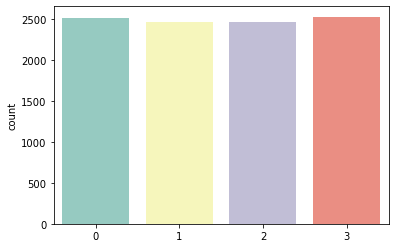

In [40]:
#count labels

sns_count = sns.countplot(train_labels, palette='Set3')
#we can see each categroy has equal data
figure = sns_count.get_figure()    
figure.savefig('count.png', dpi=400)

# Displaying a single random image

In [7]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

9955


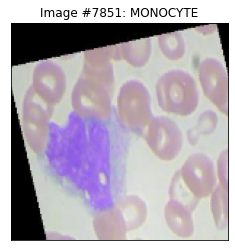

In [35]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)



The pixel values of RGB images are integer values between 0 and 255. So here we normalized the data so pixel values are in the range of 0-1 to increase computational speed.

In [10]:
 train_images = train_images/255.0
 test_images = test_images/255.0
 val_images = val_images/255.0

# **Build CNN Model**

Create a CNN model and use that model to train the dataset.

The CNN architecture is as follows :

1.First convolution block with 32 filters and the filter size being 3x3 and containing combinations of BatchNormalization, MaxPooling.

2.Second convolution block with 64 filters and the filter size being 3x3 and containing combinations of SeparableConv2D, BatchNormalization, MaxPooling.

3.Third convolution block with 128 filters and the filter size being 3x3 and containing combinations of SeparableConv2D, BatchNormalization, MaxPooling and Dropout layers.

4.Fourth convolution block with 256 filters and the filter size being 3x3 and containing combinations of SeparableConv2D, BatchNormalization, MaxPooling and Dropout layers.

5.The output of the final Conv block is flattened

5.Converting the matrix to a three fully connected layer with combination of Dropout layer.

6.A final FC layer is added with four units and a softmax activation for multiclass classification.

In [36]:
def build_model():
    """
    Create a CNN model and use that model to train the dataset.

    CNN with depthwise separable convolutions better infer the hidden features.

    Depth wise separable CNN have lesser number of parameters to adjust as compared to the standard CNN’s, which reduces overfitting
    Depth wise separable CNN are computationally cheaper because of fewer computations which makes them suitable for mobile vision applications

    """
    
    
    model = Sequential()
    #First convolution block
    model.add(Conv2D(32 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
    model.add(Conv2D(32 , (3,3) , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    #Second convolution block
    model.add(SeparableConv2D(64 , (3,3) , padding = 'same' , activation = 'relu'))
    model.add(SeparableConv2D(64 , (3,3) , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    #Third convolution block
    model.add(SeparableConv2D(128 , (3,3) , padding = 'same' , activation = 'relu'))
    model.add(SeparableConv2D(128 , (3,3) , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))
    
    #Fourth convolution block
    model.add(SeparableConv2D(256 , (3,3) , padding = 'same' , activation = 'relu'))
    model.add(SeparableConv2D(256 , (3,3) , padding = 'same' , activation = 'relu'))
    model.add(SeparableConv2D(256 , (3,3) , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))
    
    #FC layer
    model.add(Flatten())
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = 'relu'))
    
    #Output layer
    model.add(Dense(4, activation = 'softmax'))

    return model

# **Compile the Model**

Compiling the model using RMSprop as a optimizer

In [37]:
model = build_model()
#Compile
model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
separable_conv2d_24 (Separab (None, 75, 75, 64)        2400      
_________________________________________________________________
separable_conv2d_25 (Separab (None, 75, 75, 64)        4736      
_________________________________________________________________
batch_normalization_17 (Batc (None, 75, 75, 64)        2

CALLBACK

ModelCheckpoint callback is used along with training using model.fit() to save a model or weights(in a checkpoint file) 
at some interval.

ReduceLROnPlateau callback is used for reduce learning rate when a metric has stopped improving.

TensorBoard callback logs includes Metrics summary plots, Training graph visualization, Activation histograms, 
Sampled profiling 

In [38]:
# Implement callbacks
checkpoint = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)


learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, 
                                            verbose = 1, factor = 0.3, min_lr = 0.0000001)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [39]:
#Train the Model

history = model.fit(train_images, train_labels, 
                     batch_size = 32, epochs = 20, 
                     validation_data=(val_images, val_labels), 
                     callbacks=[learning_rate_reduction, checkpoint, tensorboard_callback])


Epoch 1/20
312/312 [==============================] - 34s 103ms/step - loss: 1.2555 - accuracy: 0.3918 - val_loss: 1.4882 - val_accuracy: 0.2530
Epoch 2/20
312/312 [==============================] - 31s 101ms/step - loss: 0.5940 - accuracy: 0.7698 - val_loss: 10.2305 - val_accuracy: 0.2530
Epoch 3/20
312/312 [==============================] - 31s 101ms/step - loss: 0.3989 - accuracy: 0.8614 - val_loss: 12.1016 - val_accuracy: 0.3197
Epoch 4/20
312/312 [==============================] - 31s 101ms/step - loss: 0.3202 - accuracy: 0.8953 - val_loss: 11.5496 - val_accuracy: 0.2610
Epoch 5/20
312/312 [==============================] - 32s 101ms/step - loss: 0.2486 - accuracy: 0.9102 - val_loss: 10.4118 - val_accuracy: 0.2635

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/20
312/312 [==============================] - 31s 101ms/step - loss: 0.1430 - accuracy: 0.9419 - val_loss: 2.5370 - val_accuracy: 0.7141
Epoch 7/20
312/312 [=========================

To load the tensorboard run the following command 

In [31]:
%tensorboard --logdir logs/fit 

# **Evaluation on Test Set**

In [41]:
results = model.evaluate(test_images, test_labels)

print("Loss of the model:",  results[0])
print("Accuracy: %.3f%%" % (results[1] * 100.0))

39/39 [==============================] - 1s 17ms/step - loss: 0.0459 - accuracy: 0.9928
Loss of the model: 0.04594637453556061
Accuracy: 99.277%


In [42]:
#Evaluating predictions of test data from trained model
predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)

In [43]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


# **Plotting the Curves**

The example collects the history, returned from training the model and creates two charts:

1. A plot of accuracy on the training and validation datasets over training epochs.

2. A plot of loss on the training and validation datasets over training epochs.

In [48]:
def plot_evaluation_charts(history):
    # summarize history for accuracy

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.savefig('acc_blood.png')
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.savefig('loss_blood.png')

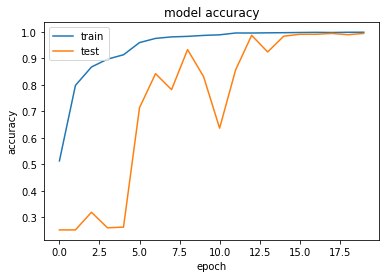

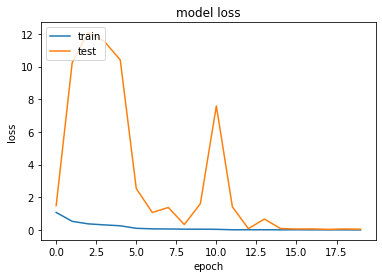

<Figure size 432x288 with 0 Axes>

In [49]:
#plot the evaluation charts
plot_evaluation_charts(history)

In [51]:
#Classifiaction Report
print(classification_report(test_labels, 
                            predictions, 
               target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.99      0.98      0.99       294
LYMPHOCYTE (Class 1)       1.00      1.00      1.00       320
  MONOCYTE (Class 2)       1.00      1.00      1.00       317
NEUTROPHIL (Class 3)       0.98      0.99      0.99       313

            accuracy                           0.99      1244
           macro avg       0.99      0.99      0.99      1244
        weighted avg       0.99      0.99      0.99      1244



In [52]:
"""
install mlxtend package to plot confusion matrix

"""
#!pip install mlxtend 

'\ninstall mlxtend package to plot confusion matrix\n\n'

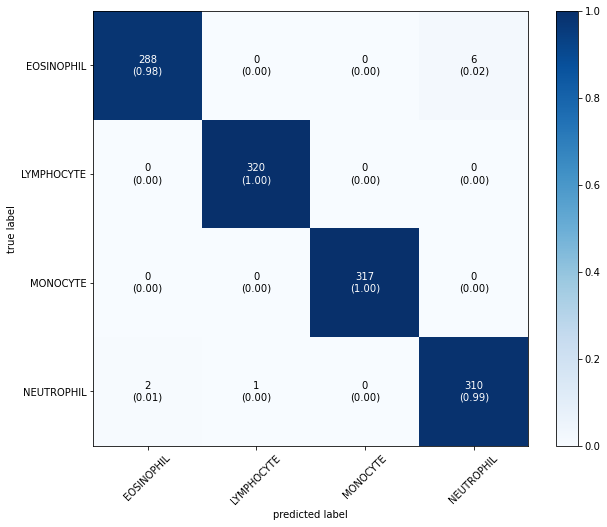

In [58]:
#Plotting the confusion matrix
from matplotlib.figure import Figure
matrix = confusion_matrix(test_labels, predictions)

class_names= ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

fig, ax = plot_confusion_matrix(conf_mat=matrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,figsize=(10, 8),
                               class_names=class_names)
plt.show()